In [1]:
library(lme4) # necessary for model fitting: glm
library(effects) # necessary for making effect plots
library(blmeco) # necessary for calculating dispersion with GLMM models

Loading required package: Matrix
Loading required package: carData
lattice theme set by effectsTheme()
See ?effectsTheme for details.
Loading required package: MASS


# Statistics based on correspondent connection types (domain types)

The frequencies in the columns (e.g. "hit_freq") represent the number of divine appeals per 100,000 words of total words per correspondent connection type. This notebook analyses the hit frequencies of the different domains in which divine appeals are made (travel & transport, trade & finances, health & sickness, politics, social)

In [11]:
jeake_conn <- read.delim(file = "stats_jeake.tsv", sep = "\t", header = T)

In [3]:
head(jeake_conn)

str(jeake_conn)

id,hit_freq,conf_freq,approve_freq,fixed_freq,object_freq,grat_freq,pray_freq,preserve_freq,presupp_freq,...,sender_generation,addressee_generation,sender_is_older,sender_over_40,addressee_over_40,age_gap_over_20,age_gap,gender_sender,gender_addressee,gender_pair
1,101.41,0,0,12.68,0,0,0.00,0.00,63.38,...,1600-1640,UNK,UNK,FALSE,UNK,UNK,NA,MALE,FEMALE,MALE-FEMALE
3,240.84,0,0,12.68,0,0,63.38,25.35,0.00,...,1600-1640,UNK,UNK,FALSE,MULT,UNK,NA,MALE,MULT,MALE-MULT
5,0.00,0,0,0.00,0,0,0.00,0.00,0.00,...,1600-1640,1600-1640,TRUE,FALSE,FALSE,FALSE,NA,MALE,FEMALE,MALE-FEMALE
6,25.35,0,0,0.00,0,0,0.00,0.00,0.00,...,1600-1640,1600-1640,FALSE,FALSE,FALSE,FALSE,7,FEMALE,MALE,FEMALE-MALE
7,12.68,0,0,0.00,0,0,0.00,0.00,0.00,...,1600-1640,1600-1640,TRUE,FALSE,FALSE,FALSE,7,MALE,FEMALE,MALE-FEMALE
8,0.00,0,0,0.00,0,0,0.00,0.00,0.00,...,1600-1640,1600-1640,FALSE,FALSE,FALSE,FALSE,7,MALE,FEMALE,MALE-FEMALE


'data.frame':	277 obs. of  35 variables:
 $ id                  : int  1 3 5 6 7 8 10 11 12 13 ...
 $ hit_freq            : num  101.4 240.8 0 25.4 12.7 ...
 $ conf_freq           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ approve_freq        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ fixed_freq          : num  12.7 12.7 0 0 0 ...
 $ object_freq         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ grat_freq           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ pray_freq           : num  0 63.4 0 0 0 ...
 $ preserve_freq       : num  0 25.4 0 0 0 ...
 $ presupp_freq        : num  63.4 0 0 0 0 ...
 $ resign_freq         : num  12.7 25.4 0 12.7 12.7 ...
 $ travel_freq         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ trade_freq          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ health_freq         : num  88.7 12.7 0 0 0 ...
 $ politics_freq       : num  0 76.1 0 0 0 ...
 $ social_freq         : num  0 12.7 0 12.7 12.7 ...
 $ connection          : Factor w/ 5 levels "BUSINESS; CORRESPONDENT",..: 5 5 5 5 5 5 5 4 4 4 ...
 $ sender              :

The "id" and "year" columns should be cast as factors.

In [12]:
jeake_conn$id <- as.factor(jeake_conn$id)
str(jeake_conn$id)

jeake_conn$year <- as.factor(jeake_conn$year)
str(jeake_conn$year)

 Factor w/ 277 levels "1","3","5","6",..: 1 2 3 4 5 6 7 8 9 10 ...
 Factor w/ 30 levels "1640","1650",..: 1 NA 2 2 2 2 2 NA 3 3 ...


In [5]:
jeake_conn <- na.omit(jeake_conn[!is.na(jeake_conn$year), ])

In [6]:
jeake_conn <- subset(jeake_conn, !(grepl("FRIEND", connection) & connection != "BUSINESS; FRIEND"))
jeake_conn$connection <- droplevels(jeake_conn$connection)

str(jeake_conn$connection)

 Factor w/ 3 levels "BUSINESS; FRIEND",..: 3 3 3 3 3 3 3 3 3 3 ...


In [13]:
# test for data independence

length(jeake_conn$id)
length(unique(jeake_conn$id))

length(jeake_conn$id) == length(unique(jeake_conn$id))

[1] 277

[1] 277

[1] TRUE

In [14]:
# test for normality

shapiro.test(jeake_conn$travel_freq)


	Shapiro-Wilk normality test

data:  jeake_conn$travel_freq
W = 0.11895, p-value < 2.2e-16


The data is not normally distributed. 

In [9]:
# remove "UNK" and "MULT" values from age_gap_over_20 column
j_gap <- jeake_conn[!(jeake_conn$age_gap_over_20 %in% c("MULT", "UNK")),  ]
j_gap$age_gap_over_20 <- droplevels(j_gap$age_gap_over_20)

# remove "UNK" and "MULT" values from sender_is_older column
j_old <- jeake_conn[!(jeake_conn$sender_is_older %in% c("MULT", "UNK")),  ]
j_old$sender_is_older <- droplevels(j_old$sender_is_older)

# remove "UNK" and "MULT" values from sender_over_40 column
j_se40 <- jeake_conn[!(jeake_conn$sender_over_40 %in% c("MULT", "UNK")),  ]
j_se40$sender_over_40 <- droplevels(j_se40$sender_over_40)

# remove "UNK" and "MULT" values from addressee_over_40 column
j_ad40 <- jeake_conn[!(jeake_conn$addressee_over_40 %in% c("MULT", "UNK")),  ]
j_ad40$addressee_over_40 <- droplevels(j_ad40$addressee_over_40)

# remove multigender values from gender_pair column
j_gender <- jeake_conn[!(jeake_conn$gender_pair %in% c("FEMALE-MULT", "MALE-MULT")),  ]
j_gender$gender_pair <- droplevels(j_gender$gender_pair)

"age_gap_over_20:"
levels(j_gap$age_gap_over_20)
nrow(j_gap)

"sender_is_older:"
levels(j_old$sender_is_older)
nrow(j_old)

"sender_over_40:"
levels(j_se40$sender_over_40)
nrow(j_se40)

"addressee_over_40:"
levels(j_ad40$addressee_over_40)
nrow(j_ad40)

"gender_pair:"
levels(j_gender$gender_pair)
nrow(j_gender)

[1] "age_gap_over_20:"

[1] "FALSE" "TRUE"

[1] 149

[1] "sender_is_older:"

[1] "FALSE" "TRUE"

[1] 149

[1] "sender_over_40:"

[1] "FALSE" "TRUE"

[1] 149

[1] "addressee_over_40:"

[1] "FALSE" "TRUE"

[1] 149

[1] "gender_pair:"

[1] "FEMALE-FEMALE" "FEMALE-MALE"   "MALE-FEMALE"   "MALE-MALE"

[1] 149

## 1 Travel & transport

### 1.1 Generalised linear mixed-effects model using "connection" as a fixed effect and "sender" as a random effect, negative binomial

In [15]:
j_lm1 <- lm(travel_freq ~ connection,
           data = jeake_conn)

summary(j_lm1)


Call:
lm(formula = travel_freq ~ connection, data = jeake_conn)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1251 -0.0717 -0.0717 -0.0717  6.7549 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)
(Intercept)                 1.489e-17  1.021e-01   0.000    1.000
connectionBUSINESS; FRIEND -8.434e-17  1.389e-01   0.000    1.000
connectionEXTENDED FAMILY   1.251e-01  1.215e-01   1.029    0.304
connectionFAMILY            7.172e-02  1.090e-01   0.658    0.511
connectionFRIEND            4.510e-17  1.924e-01   0.000    1.000

Residual standard error: 0.4894 on 272 degrees of freedom
Multiple R-squared:  0.006921,	Adjusted R-squared:  -0.007683 
F-statistic: 0.4739 on 4 and 272 DF,  p-value: 0.7549


In [20]:
j_glmer1 <- glmer(travel_freq ~ connection + (1|sender),
                  data=jeake_conn,
                  family=negative.binomial(theta=1),
                  nAGQ=0L)

summary(j_glmer1)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer1)

"------------------------------drop1------------------------------"
drop1(j_glmer1, test = "Chisq")

effect("connection", j_glmer1)

plot(effect("connection", j_glmer1))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: travel_freq ~ connection + (1 | sender)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   129.9    151.3    -58.9    117.9      257 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5824 -0.2161 -0.1815 -0.1411  8.7151 

Random effects:
 Groups Name        Variance Std.Dev.
 sender (Intercept) 2.053    1.433   
Number of obs: 263, groups:  sender, 31

Fixed effects:
                            Estimate Std. Error z value Pr(>|z|)
(Intercept)                 -22.2729  6586.3292  -0.003    0.997
connectionBUSINESS; FRIEND    0.4811  9112.7640   0.000    1.000
connectionEXTENDED FAMILY    19.2342  6586.3293   0.003    0.998
connectionFAMILY             18.9606  6586.3292   0.003    0.998

Correlation of Fixed Effects:
            (Intr) cBUSIF cEXTEF
cBUSINESS;F -0.723              
cEXTENDEDF

[1] "------------------------------dispersion------------------------------"

[1] 0.5381229

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,129.8988,NA,NA
connection,3,128.3585,4.459744,0.2159092



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
           2.123262e-10            3.435256e-10            4.789698e-02 
                 FAMILY 
           3.643404e-02 

ERROR: Error in grid::grid.pretty(range.labels): infinite axis extents [GEPretty(2.22045e-16,inf,5)]


With only 8 data points having values that differentiate from 0, it is possible that there is insufficient variance within the travel & transport frequencies to build a working model.

## 2 Trade & finances

### 2.1 Generalised linear mixed-effects model using "connection" as a fixed effect and "sender" as a random effect, negative binomial

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: trade_freq ~ connection + (1 | sender)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   255.2    276.6   -121.6    243.2      257 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9307 -0.3268 -0.2433 -0.1285 13.2533 

Random effects:
 Groups Name        Variance Std.Dev.
 sender (Intercept) 5.464    2.338   
Number of obs: 263, groups:  sender, 31

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -0.7088     0.7314  -0.969   0.3325    
connectionBUSINESS; FRIEND  -0.9915     2.0904  -0.474   0.6353    
connectionEXTENDED FAMILY   -2.9137     1.5508  -1.879   0.0603 .  
connectionFAMILY            -3.1083     0.6226  -4.993 5.95e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effe

[1] "------------------------------dispersion------------------------------"

[1] 0.7618204

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,255.2031,NA,NA
connection,3,282.9257,33.7226,2.26715e-07



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
             0.49222832              0.18262838              0.02671416 
                 FAMILY 
             0.02199115 

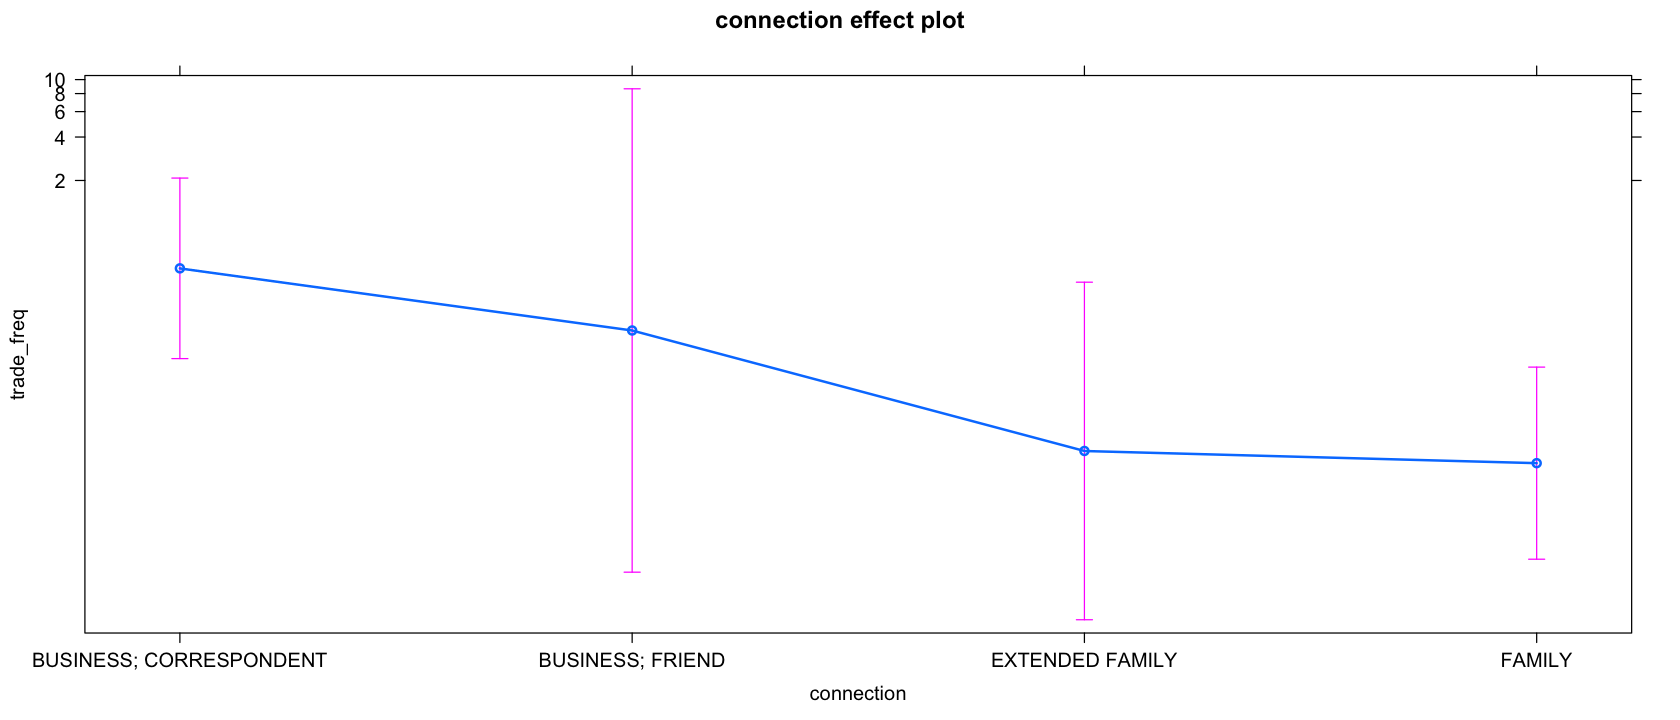

In [24]:
j_glmer2 <- glmer(trade_freq ~ connection + (1|sender),
                  data=jeake_conn,
                  family=negative.binomial(theta=1),
                  nAGQ=0L)

summary(j_glmer2)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer2)

"------------------------------drop1------------------------------"
drop1(j_glmer2, test = "Chisq")

effect("connection", j_glmer2)

plot(effect("connection", j_glmer2))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

### 2.2 Generalised linear mixed-effects model using "connection" as a fixed effect, and "pair" as a random effect, negative binomial

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: trade_freq ~ connection + (1 | pair)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   230.3    251.8   -109.2    218.3      257 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9019 -0.2675 -0.1611 -0.0878 14.6030 

Random effects:
 Groups Name        Variance Std.Dev.
 pair   (Intercept) 6.909    2.629   
Number of obs: 263, groups:  pair, 57

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -1.0655     0.7314  -1.457   0.1451    
connectionBUSINESS; FRIEND  -1.8851     0.7988  -2.360   0.0183 *  
connectionEXTENDED FAMILY   -3.6845     0.7672  -4.803 1.57e-06 ***
connectionFAMILY            -2.3809     0.4995  -4.766 1.88e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:

[1] "------------------------------dispersion------------------------------"

[1] 0.6926661

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,230.3180,NA,NA
connection,3,271.6994,47.38138,2.883364e-10



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
            0.344540196             0.052308543             0.008651572 
                 FAMILY 
            0.031858076 

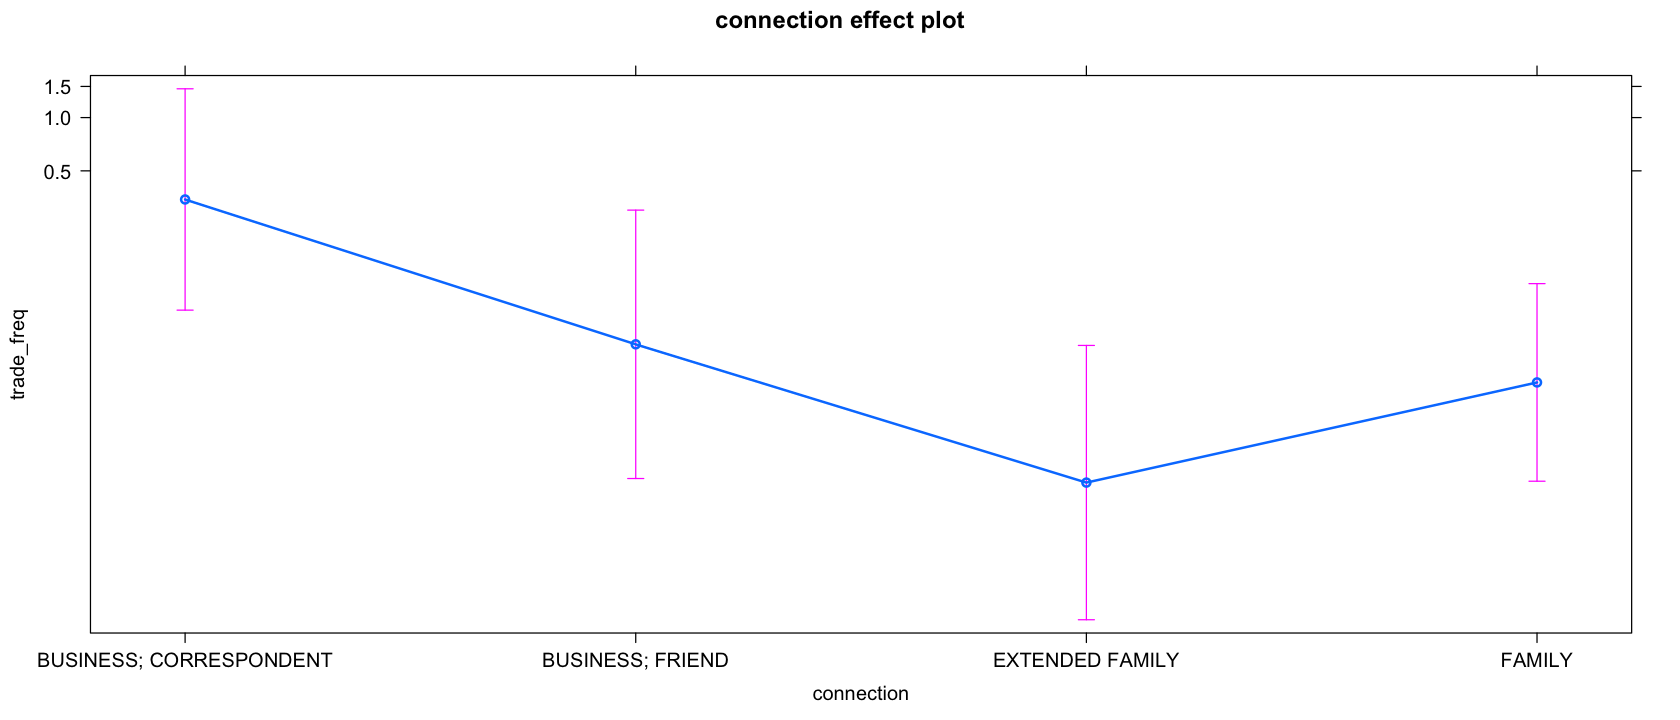

In [25]:
j_glmer2b <- glmer(trade_freq ~ connection + (1|pair),
                   data=jeake_conn,
                   family=negative.binomial(theta=1),
                   nAGQ=0L)

summary(j_glmer2b)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer2b)

"------------------------------drop1------------------------------"
drop1(j_glmer2b, test = "Chisq")

effect("connection", j_glmer2b)

plot(effect("connection", j_glmer2b))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

### 2.3 Generalised linear mixed-effects model using "connection" as a fixed effect, and "sender" and "quinquennial" as random effects, negative binomial

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: trade_freq ~ connection + (1 | sender) + (1 | quinquennial)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   252.5    277.5   -119.3    238.5      256 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9302 -0.3014 -0.1726 -0.1392 13.1178 

Random effects:
 Groups       Name        Variance Std.Dev.
 sender       (Intercept) 5.367    2.317   
 quinquennial (Intercept) 1.533    1.238   
Number of obs: 263, groups:  sender, 31; quinquennial, 12

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)  
(Intercept)                 -2.0215     0.9722  -2.079   0.0376 *
connectionBUSINESS; FRIEND  -0.1036     2.1598  -0.048   0.9618  
connectionEXTENDED FAMILY   -2.1504     1.5706  -1.369   0.1709  
connectionFAMILY            -1.7157     0.7926  -2.165   0.0304 *
---
Sign

[1] "------------------------------dispersion------------------------------"

[1] 0.728576

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,252.5164,NA,NA
connection,3,253.8174,7.301,0.06289823



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
             0.13245823              0.11942838              0.01542343 
                 FAMILY 
             0.02382155 

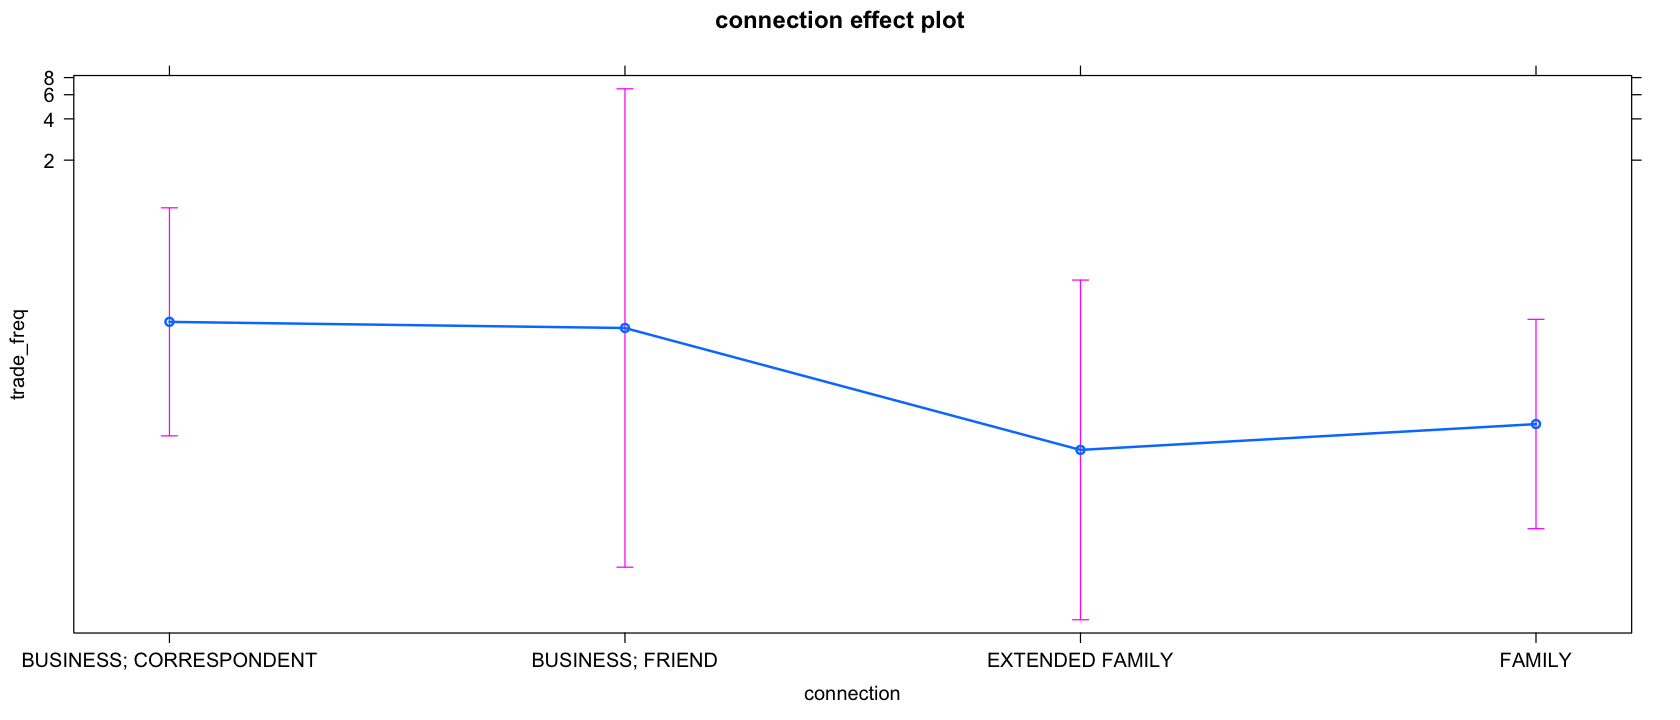

In [27]:
j_glmer2c <- glmer(trade_freq ~ connection + (1|sender) + (1|quinquennial),
                   data=jeake_conn,
                   family=negative.binomial(theta=1),
                   nAGQ=0L)

summary(j_glmer2c)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer2c)

"------------------------------drop1------------------------------"
drop1(j_glmer2c, test = "Chisq")

effect("connection", j_glmer2c)

plot(effect("connection", j_glmer2c))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

### 2.4 Generalised linear mixed-effects model using "connection" as a fixed effect, and "pair" and "quinquennial" as random effects, negative binomial (BEST FIT)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: trade_freq ~ connection + (1 | pair) + (1 | quinquennial)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   228.3    253.3   -107.1    214.3      256 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9365 -0.2789 -0.1423 -0.0763 10.7980 

Random effects:
 Groups       Name        Variance Std.Dev.
 pair         (Intercept) 8.580    2.929   
 quinquennial (Intercept) 1.978    1.407   
Number of obs: 263, groups:  pair, 57; quinquennial, 12

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -2.1616     0.9747  -2.218  0.02657 *  
connectionBUSINESS; FRIEND  -1.0337     0.8523  -1.213  0.22519    
connectionEXTENDED FAMILY   -3.3695     0.8023  -4.200 2.67e-05 ***
connectionFAMILY            -1.6033     0.5275  -3.039  0.00237 ** 
--

[1] "------------------------------dispersion------------------------------"

[1] 0.6604921

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,228.2912,NA,NA
connection,3,246.7691,24.47789,1.985115e-05



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
            0.115136579             0.040953407             0.003961518 
                 FAMILY 
            0.023169796 

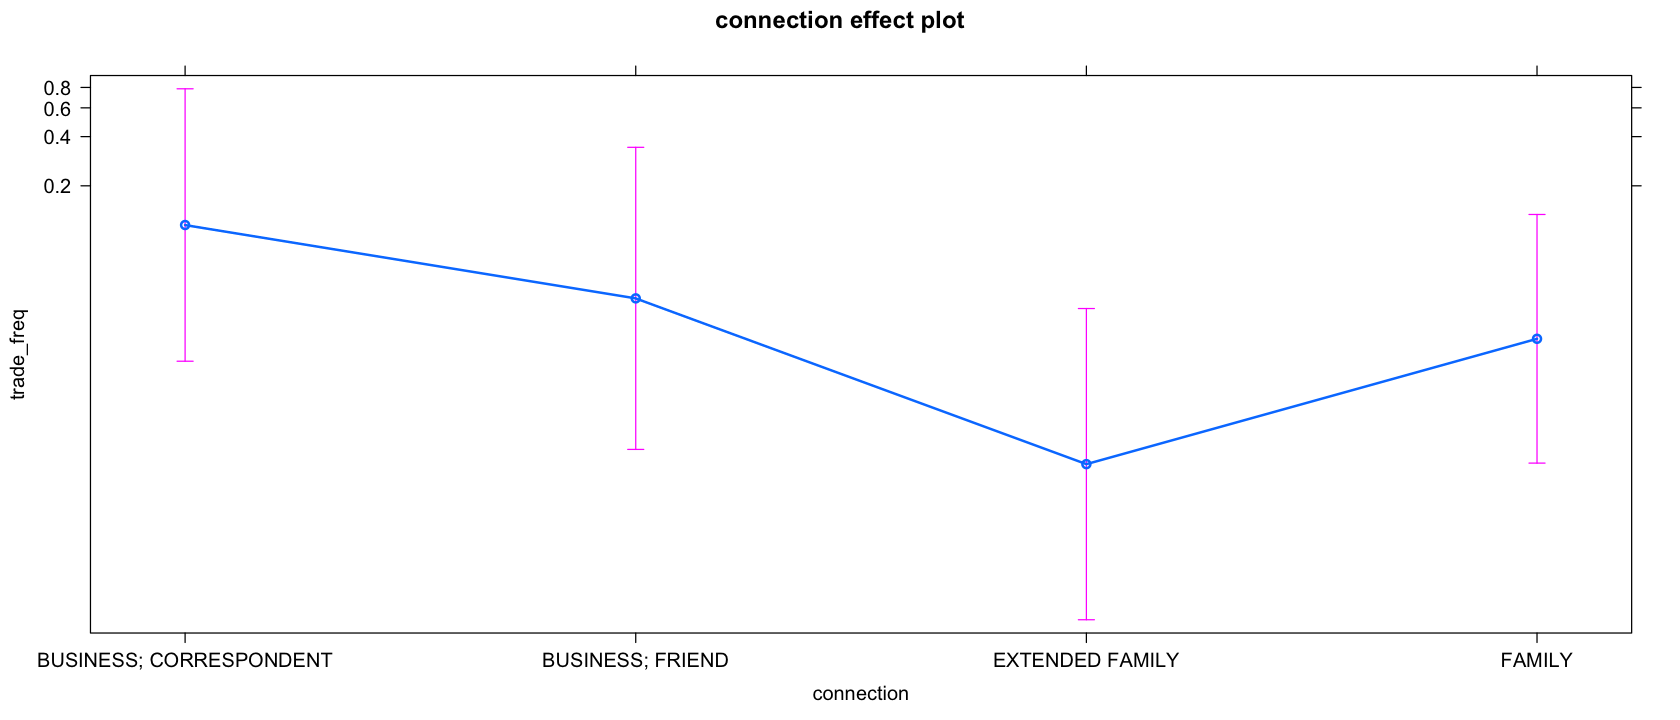

In [28]:
j_glmer2d <- glmer(trade_freq ~ connection + (1|pair) + (1|quinquennial),
                   data=jeake_conn,
                   family=negative.binomial(theta=1),
                   nAGQ=0L)

summary(j_glmer2d)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer2d)

"------------------------------drop1------------------------------"
drop1(j_glmer2d, test = "Chisq")

effect("connection", j_glmer2d)

plot(effect("connection", j_glmer2d))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

## 3 Health & sickness

### 3.1 Generalised linear mixed-effects model using "connection" as a fixed effect and "sender" as a random effect, negative binomial

In [31]:
j_glmer3 <- glmer(health_freq ~ connection + (1|sender),
                  data=jeake_conn,
                  family=negative.binomial(theta=1),
                  nAGQ=0L)

summary(j_glmer3)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer3)

"------------------------------drop1------------------------------"
drop1(j_glmer3, test = "Chisq")

effect("connection", j_glmer3)

plot(effect("connection", j_glmer3))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: health_freq ~ connection + (1 | sender)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   365.9    387.3   -176.9    353.9      257 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7867 -0.5121 -0.3316 -0.2720 10.5048 

Random effects:
 Groups Name        Variance Std.Dev.
 sender (Intercept) 1.531    1.237   
Number of obs: 263, groups:  sender, 31

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                  -19.70    2499.33  -0.008    0.994
connectionBUSINESS; FRIEND    19.20    2499.33   0.008    0.994
connectionEXTENDED FAMILY     17.86    2499.33   0.007    0.994
connectionFAMILY              17.95    2499.33   0.007    0.994

Correlation of Fixed Effects:
            (Intr) cBUSIF cEXTEF
cBUSINESS;F -1.000              
cEXTENDEDFA -1.

[1] "------------------------------dispersion------------------------------"

[1] 0.9358695

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,365.8675,NA,NA
connection,3,368.2229,8.3554,0.03921026



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
           2.768557e-09            6.049769e-01            1.575831e-01 
                 FAMILY 
           1.729224e-01 

ERROR: Error in grid::grid.pretty(range.labels): infinite axis extents [GEPretty(2.22045e-16,inf,5)]


### 3.2 Generalised linear mixed-effects model using "connection" as a fixed effect, and "pair" as a random effect, negative binomial

In [32]:
j_glmer3b <- glmer(health_freq ~ connection + (1|pair),
                   data=jeake_conn,
                   family=negative.binomial(theta=1),
                   nAGQ=0L)

summary(j_glmer3b)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer3b)

"------------------------------drop1------------------------------"
drop1(j_glmer3b, test = "Chisq")

effect("connection", j_glmer3b)

plot(effect("connection", j_glmer3b))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

ERROR: Error in pwrssUpdate(pp, resp, tol = tolPwrss, GQmat = GHrule(0L), compDev = compDev, : Downdated VtV is not positive definite


### 3.3 Generalised linear mixed-effects model using "connection" as a fixed effect, and "sender" and "quinquennial" as random effects, negative binomial

In [33]:
j_glmer3c <- glmer(health_freq ~ connection + (1|sender) + (1|quinquennial),
                   data=jeake_conn,
                   family=negative.binomial(theta=1),
                   nAGQ=0L)

summary(j_glmer3c)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer3c)

"------------------------------drop1------------------------------"
drop1(j_glmer3c, test = "Chisq")

effect("connection", j_glmer3c)

plot(effect("connection", j_glmer3c))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: health_freq ~ connection + (1 | sender) + (1 | quinquennial)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   339.0    364.0   -162.5    325.0      256 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8350 -0.4743 -0.2960 -0.2074 10.7695 

Random effects:
 Groups       Name        Variance Std.Dev.
 sender       (Intercept) 3.131    1.770   
 quinquennial (Intercept) 1.377    1.173   
Number of obs: 263, groups:  sender, 31; quinquennial, 12

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                  -23.85   11083.49  -0.002    0.998
connectionBUSINESS; FRIEND    22.41   11083.49   0.002    0.998
connectionEXTENDED FAMILY     20.60   11083.49   0.002    0.999
connectionFAMILY              21.57   11083.49   0.002    0.998

Correlation of F

[1] "------------------------------dispersion------------------------------"

[1] 0.8348696

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,338.9589,NA,NA
connection,3,343.0932,10.13431,0.01745825



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
           4.387893e-11            2.381386e-01            3.890521e-02 
                 FAMILY 
           1.024337e-01 

ERROR: Error in grid::grid.pretty(range.labels): infinite axis extents [GEPretty(2.22045e-16,inf,5)]


### 3.4 Generalised linear mixed-effects model using "connection" as a fixed effect, and "pair" and "quinquennial" as random effects, negative binomial

In [34]:
j_glmer3d <- glmer(health_freq ~ connection + (1|sender) + (1|quinquennial),
                   data=jeake_conn,
                   family=negative.binomial(theta=1),
                   nAGQ=0L)

summary(j_glmer3d)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer3d)

"------------------------------drop1------------------------------"
drop1(j_glmer3d, test = "Chisq")

effect("connection", j_glmer3d)

plot(effect("connection", j_glmer3d))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: health_freq ~ connection + (1 | sender) + (1 | quinquennial)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   339.0    364.0   -162.5    325.0      256 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8350 -0.4743 -0.2960 -0.2074 10.7695 

Random effects:
 Groups       Name        Variance Std.Dev.
 sender       (Intercept) 3.131    1.770   
 quinquennial (Intercept) 1.377    1.173   
Number of obs: 263, groups:  sender, 31; quinquennial, 12

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                  -23.85   11083.49  -0.002    0.998
connectionBUSINESS; FRIEND    22.41   11083.49   0.002    0.998
connectionEXTENDED FAMILY     20.60   11083.49   0.002    0.999
connectionFAMILY              21.57   11083.49   0.002    0.998

Correlation of F

[1] "------------------------------dispersion------------------------------"

[1] 0.8348696

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,338.9589,NA,NA
connection,3,343.0932,10.13431,0.01745825



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
           4.387893e-11            2.381386e-01            3.890521e-02 
                 FAMILY 
           1.024337e-01 

ERROR: Error in grid::grid.pretty(range.labels): infinite axis extents [GEPretty(2.22045e-16,inf,5)]


Unfortunately, none of the models work with calculating the health frequencies.

## 4 Politics

### 4.1 Generalised linear mixed-effects model using "connection" as a fixed effect and "sender" as a random effect, negative binomial

In [35]:
j_glmer4 <- glmer(politics_freq ~ connection + (1|sender),
                  data=jeake_conn,
                  family=negative.binomial(theta=1),
                  nAGQ=0L)

summary(j_glmer4)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer4)

"------------------------------drop1------------------------------"
drop1(j_glmer4, test = "Chisq")

effect("connection", j_glmer4)

plot(effect("connection", j_glmer4))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: politics_freq ~ connection + (1 | sender)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   144.5    165.9    -66.2    132.5      257 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5364 -0.4084 -0.1688  0.0000 13.4599 

Random effects:
 Groups Name        Variance Std.Dev.
 sender (Intercept) 1.226    1.107   
Number of obs: 263, groups:  sender, 31

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)
(Intercept)                -2.079e+01  4.137e+03  -0.005    0.996
connectionBUSINESS; FRIEND  1.950e+01  4.137e+03   0.005    0.996
connectionEXTENDED FAMILY   1.874e-03  4.955e+03   0.000    1.000
connectionFAMILY            1.744e+01  4.137e+03   0.004    0.997

Correlation of Fixed Effects:
            (Intr) cBUSIF cEXTEF
cBUSINESS;F -1.000              
cEX

[1] "------------------------------dispersion------------------------------"

[1] 0.6157766

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,144.4771,NA,NA
connection,3,146.0207,7.543558,0.05644977



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
           9.320508e-10            2.746138e-01            9.337994e-10 
                 FAMILY 
           3.493202e-02 

ERROR: Error in grid::grid.pretty(range.labels): infinite axis extents [GEPretty(2.22045e-16,inf,5)]


### 4.2 Generalised linear mixed-effects model using "connection" as a fixed effect, and "pair" as a random effect, negative binomial

In [36]:
j_glmer4b <- glmer(politics_freq ~ connection + (1|pair),
                   data=jeake_conn,
                   family=negative.binomial(theta=1),
                   nAGQ=0L)

summary(j_glmer4b)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer4b)

"------------------------------drop1------------------------------"
drop1(j_glmer4b, test = "Chisq")

effect("connection", j_glmer4b)

plot(effect("connection", j_glmer4b))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: politics_freq ~ connection + (1 | pair)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   118.9    140.3    -53.4    106.9      257 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6603 -0.1186 -0.0874  0.0000  8.3428 

Random effects:
 Groups Name        Variance Std.Dev.
 pair   (Intercept) 5.766    2.401   
Number of obs: 263, groups:  pair, 57

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)
(Intercept)                  -24.3868  9271.2098  -0.003    0.998
connectionBUSINESS; FRIEND    20.2174  9271.2098   0.002    0.998
connectionEXTENDED FAMILY      0.2332 11148.4531   0.000    1.000
connectionFAMILY              19.7485  9271.2098   0.002    0.998

Correlation of Fixed Effects:
            (Intr) cBUSIF cEXTEF
cBUSINESS;F -1.000              
cEXTEND

[1] "------------------------------dispersion------------------------------"

[1] 0.5173764

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,118.8855,NA,NA
connection,3,121.9384,9.052872,0.02859613



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
           2.564233e-11            1.546249e-02            3.237686e-11 
                 FAMILY 
           9.674475e-03 

ERROR: Error in grid::grid.pretty(range.labels): infinite axis extents [GEPretty(2.22045e-16,inf,5)]


## 5 Social life

### 5.1 Generalised linear mixed-effects model using "connection" as a fixed effect and "sender" as a random effect, negative binomial

In [37]:
j_glmer5 <- glmer(politics_freq ~ connection + (1|sender),
                  data=jeake_conn,
                  family=negative.binomial(theta=1),
                  nAGQ=0L)

summary(j_glmer5)

"------------------------------dispersion------------------------------"
dispersion_glmer(j_glmer5)

"------------------------------drop1------------------------------"
drop1(j_glmer5, test = "Chisq")

effect("connection", j_glmer5)

plot(effect("connection", j_glmer5))

par(cex.axis = 0.8)

options(repr.plot.width = 14, repr.plot.height = 6)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: Negative Binomial(1)  ( log )
Formula: politics_freq ~ connection + (1 | sender)
   Data: jeake_conn

     AIC      BIC   logLik deviance df.resid 
   144.5    165.9    -66.2    132.5      257 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5364 -0.4084 -0.1688  0.0000 13.4599 

Random effects:
 Groups Name        Variance Std.Dev.
 sender (Intercept) 1.226    1.107   
Number of obs: 263, groups:  sender, 31

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)
(Intercept)                -2.079e+01  4.137e+03  -0.005    0.996
connectionBUSINESS; FRIEND  1.950e+01  4.137e+03   0.005    0.996
connectionEXTENDED FAMILY   1.874e-03  4.955e+03   0.000    1.000
connectionFAMILY            1.744e+01  4.137e+03   0.004    0.997

Correlation of Fixed Effects:
            (Intr) cBUSIF cEXTEF
cBUSINESS;F -1.000              
cEX

[1] "------------------------------dispersion------------------------------"

[1] 0.6157766

[1] "------------------------------drop1------------------------------"

,Df,AIC,LRT,Pr(Chi)
<none>,NA,144.4771,NA,NA
connection,3,146.0207,7.543558,0.05644977



 connection effect
connection
BUSINESS; CORRESPONDENT        BUSINESS; FRIEND         EXTENDED FAMILY 
           9.320508e-10            2.746138e-01            9.337994e-10 
                 FAMILY 
           3.493202e-02 

ERROR: Error in grid::grid.pretty(range.labels): infinite axis extents [GEPretty(2.22045e-16,inf,5)]


The data is insufficient to run models succesfully, and it doesn't seem to make sense to continue these experiments further.